In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/n225-daily.csv')

In [3]:
df.head()

,HIGH,LOW,OPEN,VOLUME,CLOSE
0,16089.13,15910.62,16088.54,867540000,15960.62
1,16156.78,15874.63,15955.76,869700000,15938.66
2,16005.09,15745.01,15953.08,879840000,15762.59
3,15946.42,15811.73,15881.92,773980000,15890.56
4,15962.93,15769.16,15929.90,955370000,15872.02


In [4]:
x = df.iloc[:, :-1].values.astype('f')

In [5]:
t = df.iloc[:, -1].values.astype('f')

In [6]:
x.shape

(3000, 4)

In [7]:
t.shape

(3000,)

In [8]:
t = t.reshape(len(t), 1)

In [9]:
type(x)

numpy.ndarray

In [10]:
type(t)

numpy.ndarray

In [11]:
dataset = list(zip(x, t))

In [12]:
#dataset

In [ ]:
import chainer
import chainer.functions as F
import chainer.links as L

In [14]:
n_train = int(len(dataset)*0.7)
n_train

2100

In [15]:
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=0)

In [16]:
len(train)

2100

In [17]:
len(test)

900

## モデルの定義 (Model Definition)

In [18]:
class NN(chainer.Chain):
    # モデルの構造
    def __init__(self, n_mid_units=5, n_out=1):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(None, n_out)  
            
            #self.bn = L.BatchNormalization(4)
            
    # 順伝播
    def __call__(self, x):
        #h = self.bn(x)
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [19]:
np.random.seed(0)
# インスタンス化
nn = NN()

In [20]:
model = L.Classifier(nn, lossfun=F.mean_squared_error)
model.compute_accuracy = False

### Learning configuration

### Optimizer Settings

In [23]:
optimizer = chainer.optimizers.SGD()

In [24]:
optimizer.setup(model)

### Iterator Settings

In [25]:
batchsize = 10

In [26]:
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

### Updater Settings
- CPU = -1
- GPU = 0

In [27]:
from chainer import training

In [28]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

### Trainer Extensions Settings

In [29]:
from chainer.training import extensions

In [30]:
# エポックの数
epoch = 50

In [31]:
# trainerの宣言
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/n225-sgd-50ep-noBn')

# 検証データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

# 1エポックごと（trigger）にtrainデータに対するloss・accuracyとtestデータに対するloss・accuracy,経過時間出力します。
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

## 学習の実行

In [32]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           7.14337e+13  1.0483e+09            0.30577       
2           1.4242e+08  2.06969e+07           0.61604       
3           2.01191e+07  2.05219e+07           0.910633      
4           2.01019e+07  2.05199e+07           1.19997       
5           2.01017e+07  2.05214e+07           1.50931       
6           2.0097e+07  2.05262e+07           1.80174       
7           2.00838e+07  2.0537e+07            2.09003       
8           2.00964e+07  2.05211e+07           2.38679       
9           2.00935e+07  2.05197e+07           2.68198       
10          2.00915e+07  2.0543e+07            2.98886       
11          2.00983e+07  2.05227e+07           3.27752       
12          2.0088e+07  2.05198e+07           3.58254       
13          2.01003e+07  2.05197e+07           3.88773       
14          2.00897e+07  2.05201e+07           4.19298       
15          2.00956e+07  2.05198e+07           4.49135       
16          2.

## Confirm results

In [33]:
import json

In [34]:
with open('result/n225-sgd-50ep-noBn/log') as f:
    logs = json.load(f)
    results = pd.DataFrame(logs)

In [35]:
results.head(10)

,elapsed_time,epoch,iteration,main/loss,validation/main/loss
0,0.305770,1,210,7.143365e+13,1.048299e+09
1,0.616040,2,420,1.424199e+08,2.069691e+07
2,0.910633,3,630,2.011910e+07,2.052190e+07
3,1.199969,4,840,2.010188e+07,2.051988e+07
4,1.509314,5,1050,2.010169e+07,2.052145e+07
5,1.801739,6,1260,2.009699e+07,2.052620e+07
6,2.090034,7,1470,2.008382e+07,2.053699e+07
7,2.386794,8,1680,2.009636e+07,2.052107e+07
8,2.681978,9,1890,2.009353e+07,2.051975e+07
9,2.988858,10,2100,2.009153e+07,2.054296e+07


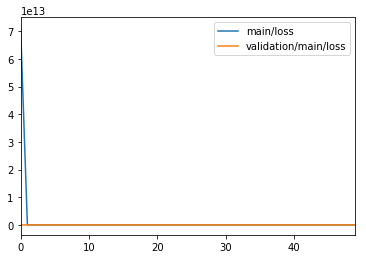

In [36]:
results[['main/loss', 'validation/main/loss']].plot()

In [37]:
loss = results['validation/main/loss'].values[-1]
loss

20526757.166666668

In [38]:
import math

In [39]:
math.sqrt(loss)

4530.646440262875